## Comparing CEDS and SNEII inventories in OsloCTM3
### Surface ozone plots, including comparison with station observations from Hakim et al 2019

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import regionmask
import geopandas as gp
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'

#***change filename here***
filename1 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS21.nc'
filename2 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS_SNEII_merged.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [3]:
# import shape file for states
zipfile = "/div/no-backup/users/zofias/India_State_Boundary.shp"
states = gp.read_file(zipfile)

In [4]:
#states

In [5]:
rcParams['font.size'] = 16

time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #[1,2,3,4,5,6,7,8,9,10,11,12]
month_labs = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Import data

In [6]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc1}{filename1}')
ds_sneii = xr.open_dataset(f'{file_loc1}{filename2}')

#calculate difference
ds_diff = ds_sneii - ds_ceds

In [7]:
#make mask for regions
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)

mask = regionmask.mask_geopandas(states, lon, lat)

/tmp/ipykernel_236992/840373041.py:5: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  mask = regionmask.mask_geopandas(states, lon, lat)


In [8]:
#import area dataset for area weighted mean
#ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
ds_delta_z = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_delta_z.nc')

box_area = ds_ceds["area"]
delta_z = ds_delta_z["delta_z"]*-1

ds_landmask = xr.open_dataset('/div/no-backup/users/zofias/landsea_OsloCTMres.nc')

ds_landmask['lat'] = ds_sneii.lat
ds_landmask['lon'] = ds_sneii.lon


weights_lat_lon_3d = np.array(60*[box_area.data]) # weights for 12 months
#weights_lat_lon_2d = box_area.data

In [9]:
#obs station labels and locations
station_lat_lons = np.array([[77.2,28.68],[76.37,30.35],[73.72,24.58],[79.97,23.15],[73.8,18.53],[78.4,17.52],[91.65,26.15],[80.13,13.03]])
station_labs = ['Delhi','Patiala','Udaipur','Jabalpur','Pune','Hyderabad','Guwahati','Chennai']

#city labels and locations
city_names = ['Mumbai','Delhi','Kolkata','Chennai','Bengalūru','Hyderabad']
city_lat_lons = np.array([[72.836447, 18.987807],[77.231495, 28.651952], [88.363044, 22.562627],[80.248357, 13.084622],[77.587106, 12.977063],[78.456355, 17.384052]])

In [10]:
#import obs data for ozone stations
o3_obs_all = pd.read_csv('/div/nac/users/zofias/SNEII/ozone_station_obs_digitised.csv',index_col=0)
o3_mod_all = pd.read_csv('/div/nac/users/zofias/SNEII/ozone_mod_stations.csv',index_col=0)

#arrays for mean, max and min from obs data
o3_obs_mean = o3_obs_all.iloc[:,:8]
o3_obs_max = o3_obs_all.iloc[:,8:16]
o3_obs_min = o3_obs_all.iloc[:,16:]

o3_mod_max = o3_mod_all.iloc[:,:8]
o3_mod_min = o3_mod_all.iloc[:,8:16]

#o3_mod_all

### Calculations: averaging, surface conc, column

In [11]:
calcs = {
    "CEDS": xr.Dataset(),
    "diff": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "diff": ds_diff,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "diff", "SNEII"]

In [12]:
#define constants
mr_o3 = 48.
mr_air = 28.97
n_a = 6.022e23

In [13]:
#calculate zonal mean
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_zonal_mean"] = (
        exp_ukca.O3 
        .mean(dim=('lon')) 
        .load()
    )

In [14]:
#select surface conc and calculate mean
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_surf"] = (
        exp_ukca.O3 
        .isel(lev = 0)
        *1e9 #convert to ppb
    )

In [15]:
#calculate total ozone burden
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_tot_burden"] = (
        (exp_ukca.O3
        *mr_o3/mr_air # convert to mass mixing ratio
        *exp_ukca.airmass) # kg
        .sum(dim=('lat','lon','lev'))
        /1e9 #convert to Tg

    )

In [16]:
#select surface conc and calculate mean
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_surf_mean"] = (
        exp_calc["O3_surf"]
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )
    
    exp_calc["O3_india_mean"] = (
        exp_calc["O3_surf"]
        .sel(lon=slice(56, 105), lat=slice(5, 38))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

In [17]:
#land mask
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_land_masked"] = (
        exp_calc.O3_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )

In [18]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["O3_india_land_mean"] = (
        exp_calc["O3_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(5, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

### Plots

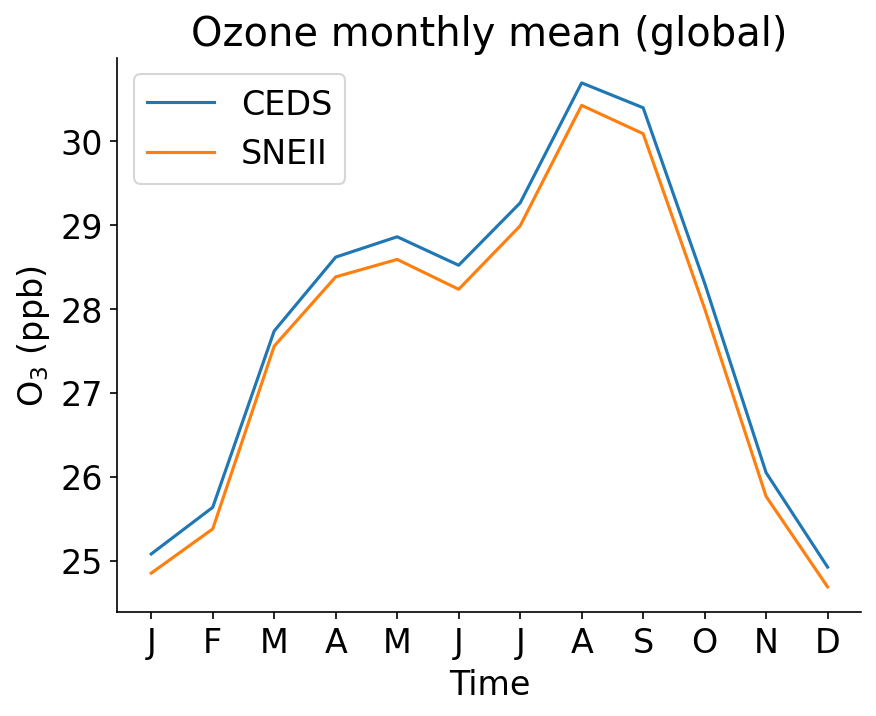

In [19]:
fig = plt.figure(dpi=150)
ax = plt.axes()

# filter df for ticker and plot on specified axes
#calcs['EMAC'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'EMAC')
calcs['CEDS'].O3_surf_mean.plot(label = 'CEDS')
#calcs['LMDZ-INCA'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'LMDZ-INCA')
calcs['SNEII'].O3_surf_mean.plot( label = 'SNEII')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# chart formatting
#ax.set_xlim(0,130)
ax.set_xticks(calcs['CEDS'].O3_surf_mean.time.data,month_labs)
plt.title(f'Ozone monthly mean (global)')
ax.set_xlabel('Time')
ax.set_ylabel(f"O$_3$ (ppb)")
plt.legend()

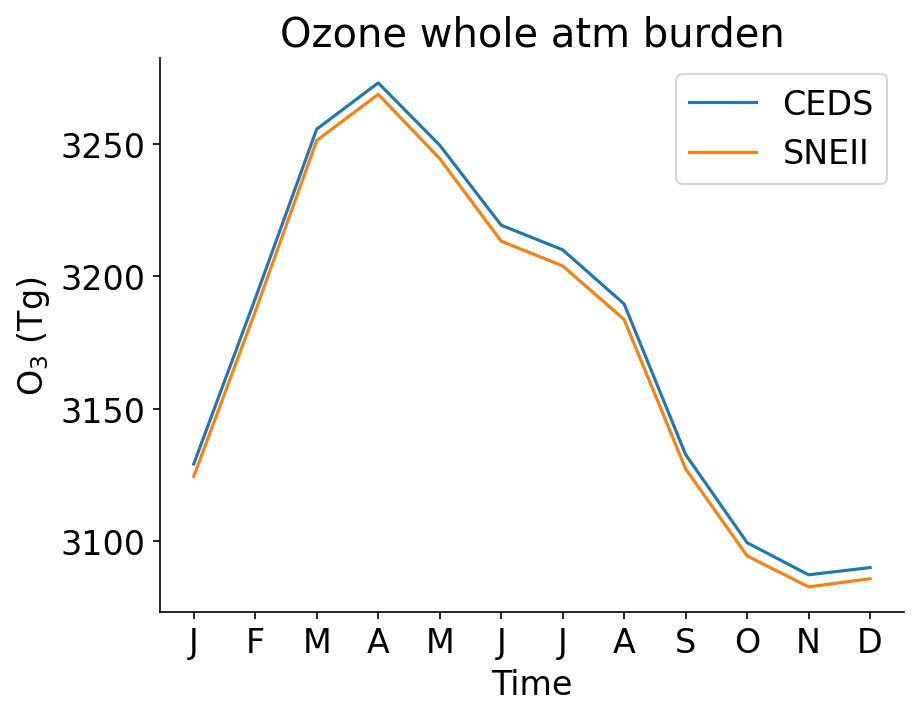

In [20]:
fig = plt.figure(dpi=150)
ax = plt.axes()

# filter df for ticker and plot on specified axes
#calcs['EMAC'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'EMAC')
calcs['CEDS'].O3_tot_burden.plot(label = 'CEDS')
#calcs['LMDZ-INCA'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'LMDZ-INCA')
calcs['SNEII'].O3_tot_burden.plot( label = 'SNEII')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# chart formatting
#ax.set_xlim(0,130)
ax.set_xticks(calcs['CEDS'].O3_surf_mean.time.data,month_labs)
plt.title(f'Ozone whole atm burden')
ax.set_xlabel('Time')
ax.set_ylabel(f"O$_3$ (Tg)")
plt.legend()

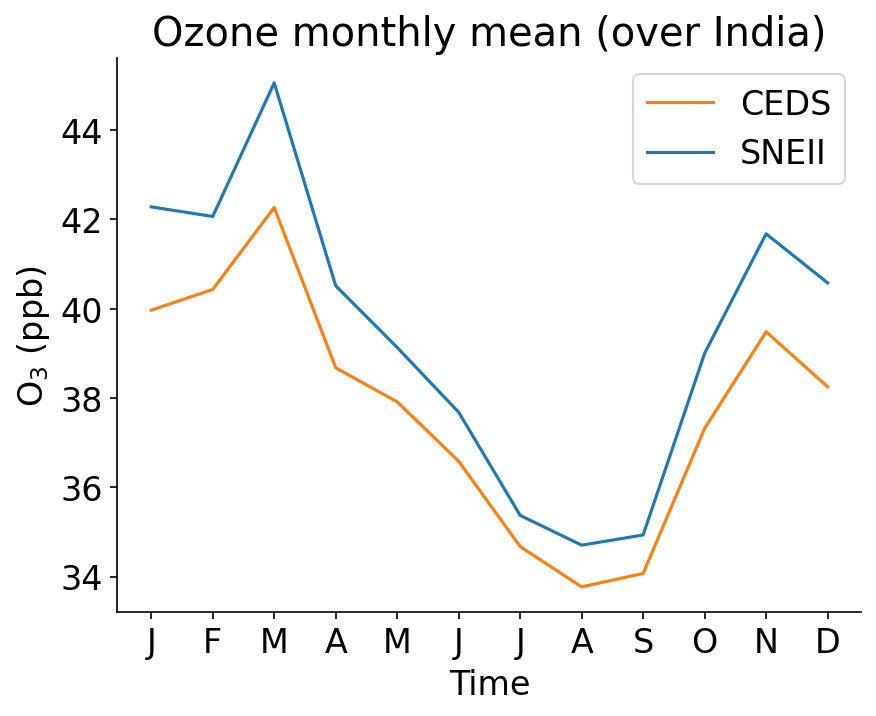

In [21]:
breakfig = plt.figure(dpi=150)
ax = plt.axes()

calcs['CEDS'].O3_india_mean.plot(label = 'CEDS', c= 'C1')
calcs['SNEII'].O3_india_mean.plot( label = 'SNEII', c= 'C0')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# chart formatting
#ax.set_xlim(0,130)
ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
plt.title('Ozone monthly mean (over India)')
ax.set_xlabel('Time')
ax.set_ylabel(f"O$_3$ (ppb)")
plt.legend()

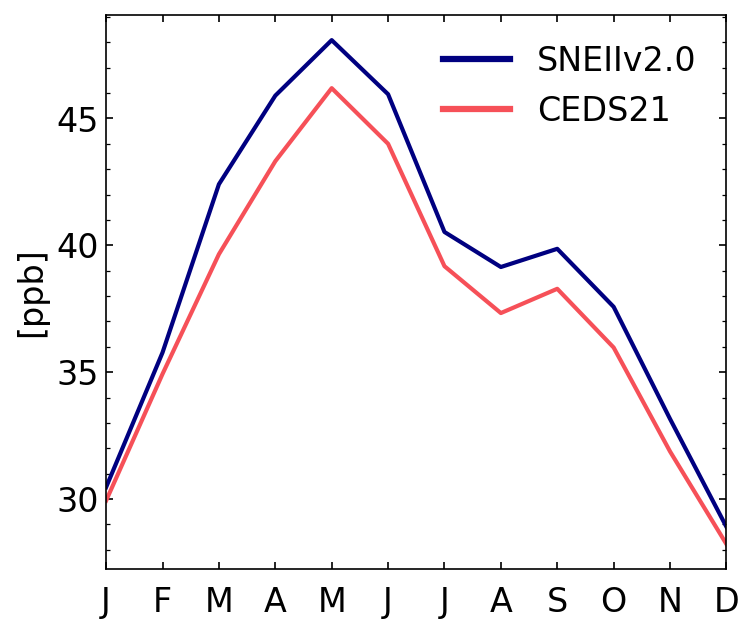

In [22]:
fig = plt.figure(dpi=150)
ax = plt.axes()

calcs['SNEII'].O3_india_land_mean.plot(label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].O3_india_land_mean.plot(label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

# chart formatting
ax.set_xlim(0,11)
ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
#plt.title('Ozone monthly mean (over India land only)')
ax.set_xlabel('')
ax.set_ylabel(f"[ppb]")
leg = plt.legend(frameon=False)
#ax.set_yticks(minor=True)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)

ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.tick_params(axis='y', which='minor', bottom=False)


for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

plt.gca().set_aspect(0.45)
#plt.savefig(f'{outfile}SNEII_CEDS_o3_surface_india_mean_land_masked_clim.pdf',format='pdf',bbox_inches='tight')


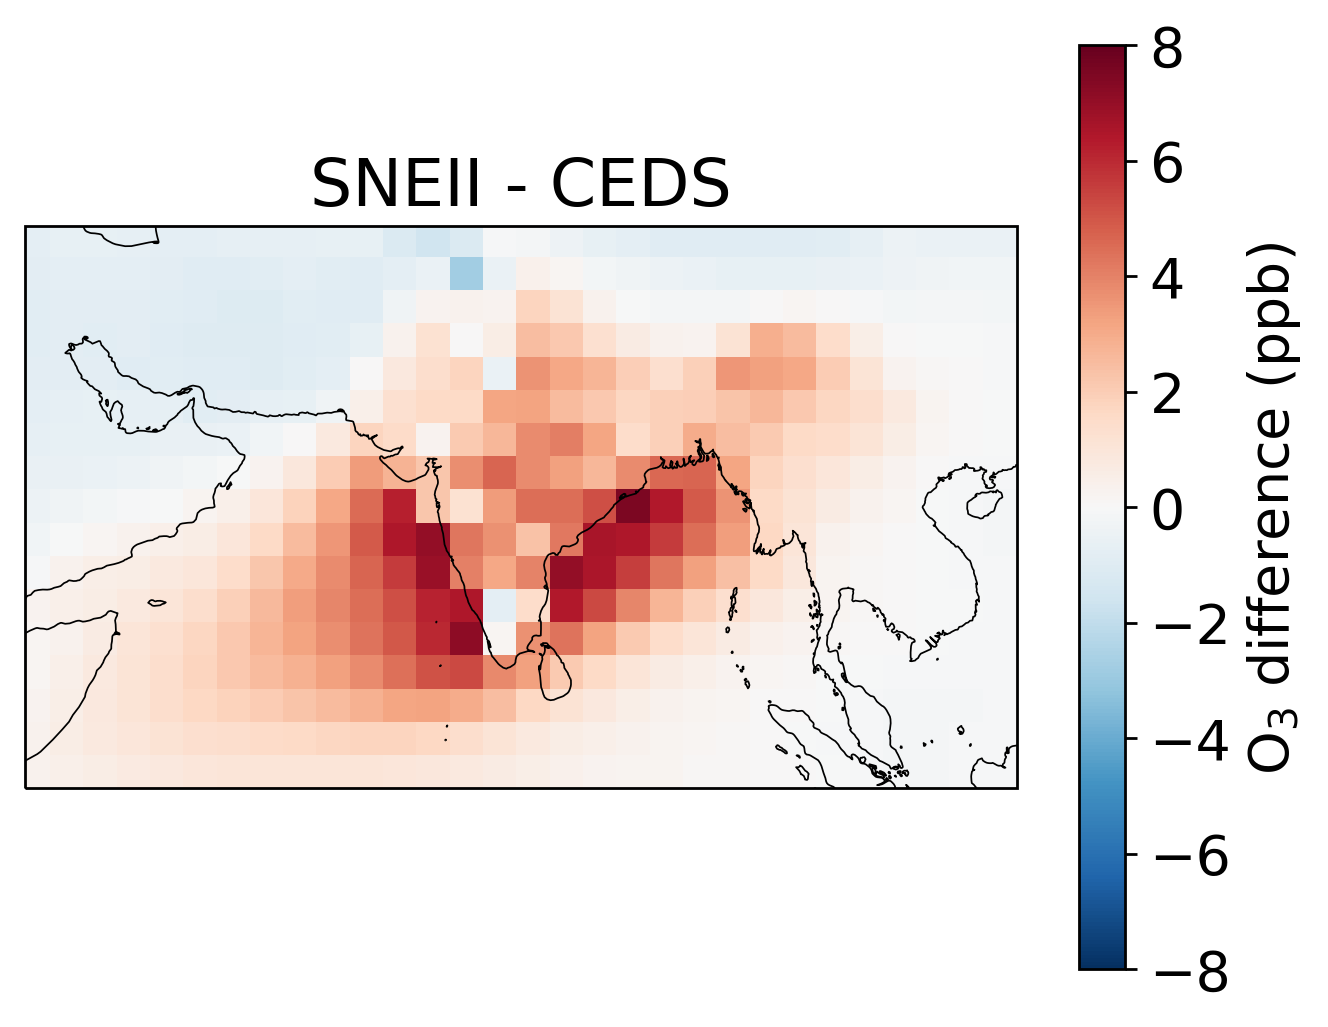

In [23]:
#fg = calcs['diff']..mean(dim='time').plot(size=5,

                                                 
fig, axis = plt.subplots(1, 1, dpi=250, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].O3_surf.mean(dim='time').sel(lon=slice(45, 112), lat=slice(0, 38)).plot(cmap="RdBu_r",
    vmax=8, vmin=-8, 
    cbar_kwargs={'label': f'O$_3$ difference (ppb)'},
    xlim=(45,112),
    ylim=(0,38),
    )

#cbar = fig.colorbar(fg, label = f'Surface O$_3$ difference (ppb)')
#cbar.set_ticks([0.5,1,2,5,10,20],labels=[0.5,1,2,5,10,20])
plt.title(f"SNEII - CEDS")
axis.coastlines(linewidth=0.5)  # cartopy function

In [24]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

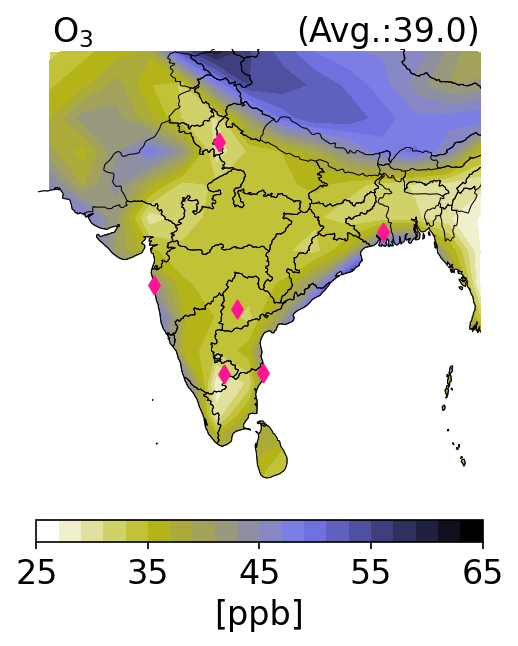

In [25]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap=cmap_ol_pu_bk,
    vmax=65, vmin=25,levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[ppb]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(25,66,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'O$_3$')
plt.text(82.5,35.5,f'(Avg.:39.0)')
plt.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='d',c='deeppink',zorder=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
#plt.title(f"SNEII - CEDS")
#plt.savefig(f'{outfile}SNEII_o3_surface_map_land_masked.pdf',format='pdf',bbox_inches='tight')

(65.0, 95.0, 5.0, 35.0)

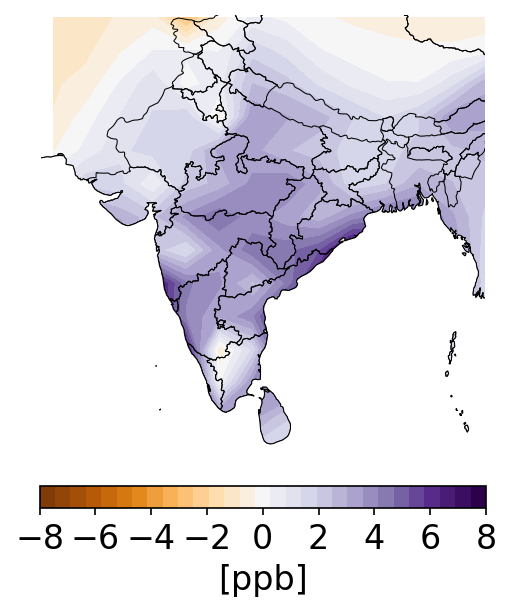

In [26]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap="PuOr",
    vmax=8, vmin=-8,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[ppb]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-8,9,2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_surface_map_land_masked.pdf',format='pdf',bbox_inches='tight')
#plt.title(f"SNEII - CEDS")

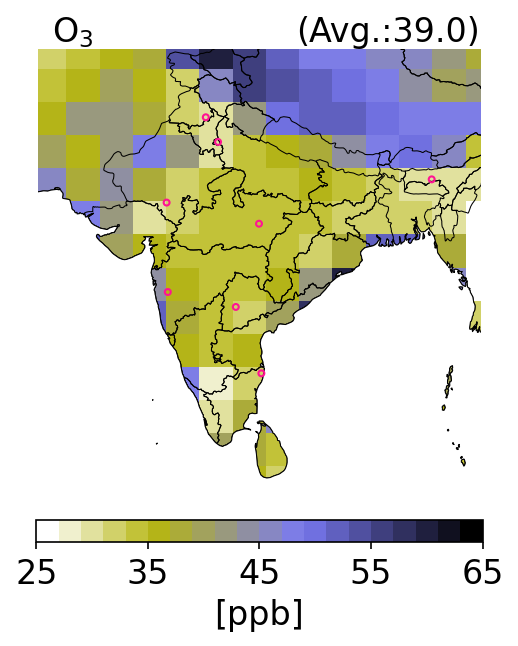

In [27]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.pcolormesh(cmap=cmap_ol_pu_bk,
    vmax=65, vmin=25,levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[ppb]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(25,66,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'O$_3$')
plt.text(82.5,35.5,f'(Avg.:39.0)')
plt.scatter(station_lat_lons[:,0],station_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=8)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
#plt.title(f"SNEII - CEDS")

['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']


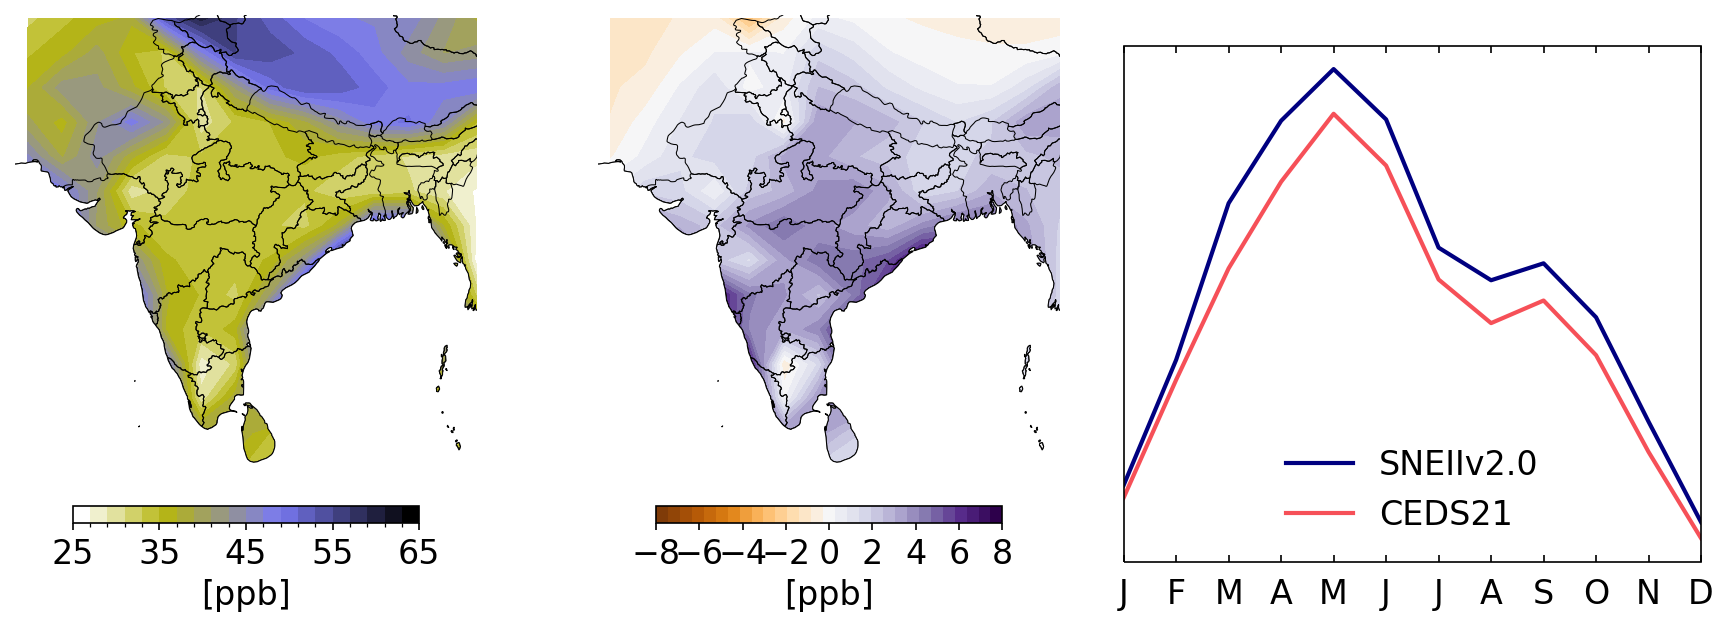

In [59]:
# Assuming 'calcs', 'cmap_ol_pu_bk', 'month_labs', 'city_lat_lons', etc., are pre-defined in your environment.

fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=65, vmin=25, levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label='[ppb]', location='bottom', pad=0.05, shrink=0.6, ticks=np.arange(25, 66, 10))
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title("SNEII - O3 Surface")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=8, vmin=-8, levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label='[ppb]', location='bottom', pad=0.05, shrink=0.6, ticks=np.arange(-8, 9, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title("SNEII - CEDS Difference")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

# Plot 3: Line plot
ax = axs[2]
calcs['SNEII'].O3_india_land_mean.plot(ax=ax, label='SNEIIv2.0', c=(0, 0, 128/255), linewidth=2)
calcs['CEDS'].O3_india_land_mean.plot(ax=ax, label='CEDS21', c=(246/255, 80/255, 88/255), linewidth=2)
ax.set_xlim(0, 11)
ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data)
ax.set_xticklabels(month_labs)

print(month_labs)
ax.set_xlabel('')
ax.tick_params(axis='y', which='both', labelleft=True)
ax.set_ylabel("[ppb]", labelpad=10)
ax.set_aspect(0.45)
leg = ax.legend(frameon=False)

ax.xaxis.set_tick_params(direction='in', which='both', top=True, pad=8)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))

plt.subplots_adjust(wspace=0.01)
# Final adjustments
#plt.tight_layout()
#plt.show()


## Plots at obs station locations

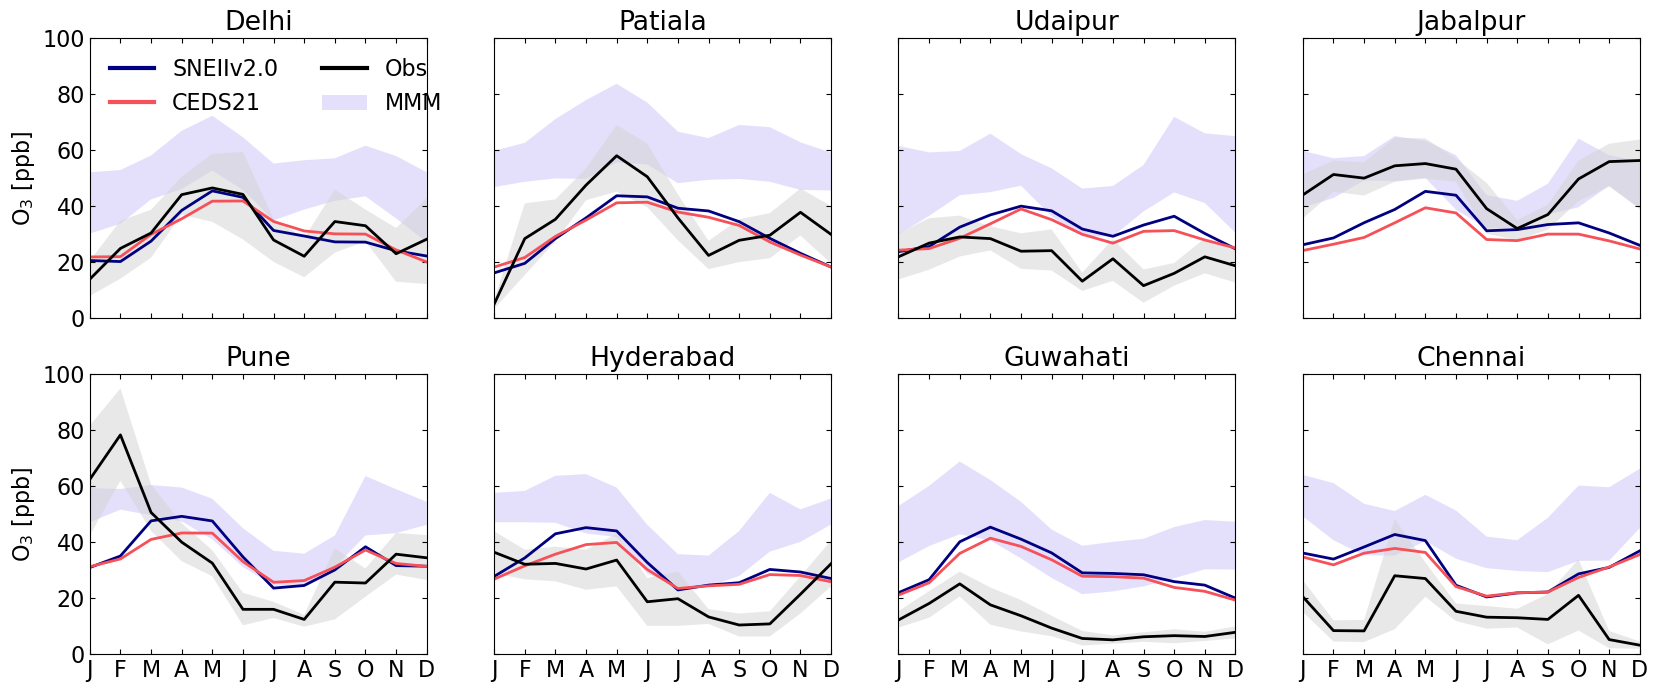

In [28]:
# Obs station plot with multi-model mean

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
#plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Surface ozone", fontsize=16, y=0.95)

# loop through tickers and axes
for ax,i in zip(axs.ravel(),np.arange(0,8)):
    # filter df for ticker and plot on specified axes
    
    calcs['SNEII'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
    calcs['CEDS'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

    ax.plot(o3_obs_mean.iloc[:,i],label = 'Obs', c= ('k'),linewidth=2,zorder=2)
    ax.fill_between(o3_obs_max.index, o3_obs_max.iloc[:,i],o3_obs_min.iloc[:,i],facecolor='lightgrey',alpha=0.5,zorder=1)

    ax.fill_between(o3_mod_max.index, o3_mod_max.iloc[:,i],o3_mod_min.iloc[:,i],facecolor='mediumslateblue',alpha=0.2,zorder=0,label='MMM')
    #calcs['OsloCTM3'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'OsloCTM3')
    #calcs['LMDZ-INCA'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'LMDZ-INCA')


    # chart formatting
    ax.set_xlim(0,11)
    ax.set_ylim(0,100)
    ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
    #ax.get_legend().remove()
    ax.set_title(station_labs[i])
    ax.set_ylabel(f'O$_3$ [ppb]')
    ax.set_xlabel("")
    ax.label_outer()
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0)

    ax.xaxis.set_tick_params(direction='in', which='both',top=True)
    ax.yaxis.set_tick_params(direction='in', which='both',right=True)

    if i == 0:
        leg = ax.legend(frameon=False,ncol=2,loc=2)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3)
        
plt.show()


fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0)


# If we don't specify the edgecolor and facecolor for the figure when
# saving with savefig, it will override the value we set earlier!
#fig.savefig('o3_stations.png', facecolor=fig.get_facecolor(), edgecolor='none')
fig.savefig(f'{outfile}station_obs_comparison_MMM.pdf',format='pdf',bbox_inches='tight')

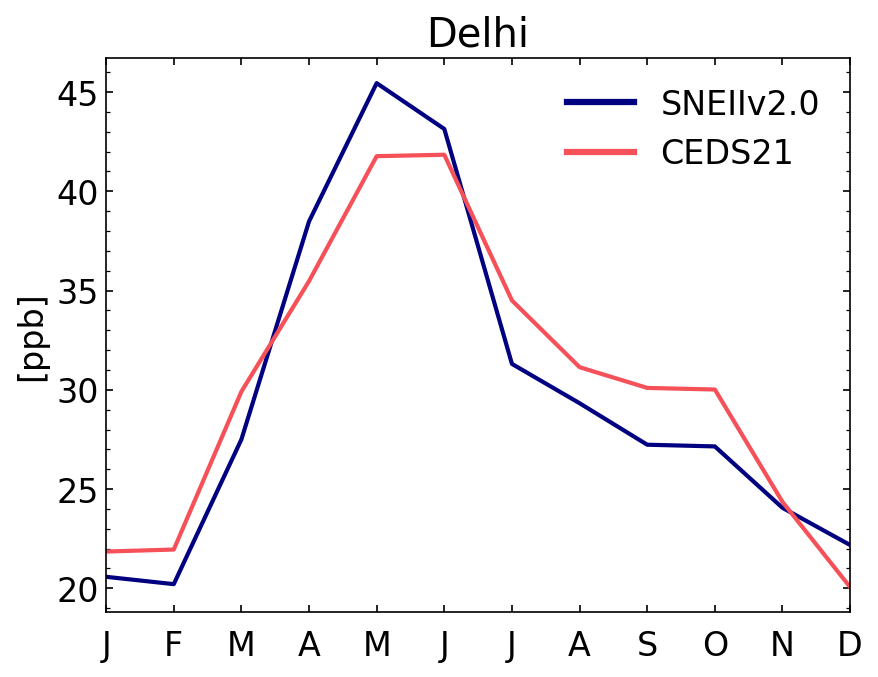

In [29]:
#OsloCTM3 station location plot for one location
fig = plt.figure(dpi=150)
ax = plt.axes()

# filter df for ticker and plot on specified axes
#calcs['EMAC'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'EMAC')
calcs['SNEII'].O3_surf.sel(lat=station_lat_lons[0,1], lon=station_lat_lons[0,0], method='nearest').plot(label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].O3_surf.sel(lat=station_lat_lons[0,1], lon=station_lat_lons[0,0], method='nearest').plot(label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)
#calcs['LMDZ-INCA'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'LMDZ-INCA')


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

# chart formatting
ax.set_xlim(0,11)
ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
#plt.title('Ozone monthly mean (over India land only)')
ax.set_xlabel('')
ax.set_ylabel(f"[ppb]")
leg = plt.legend(frameon=False)
#ax.set_yticks(minor=True)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)

ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.tick_params(axis='y', which='minor', bottom=False)

plt.title(station_labs[0])
for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

#plt.gca().set_aspect(0.45)

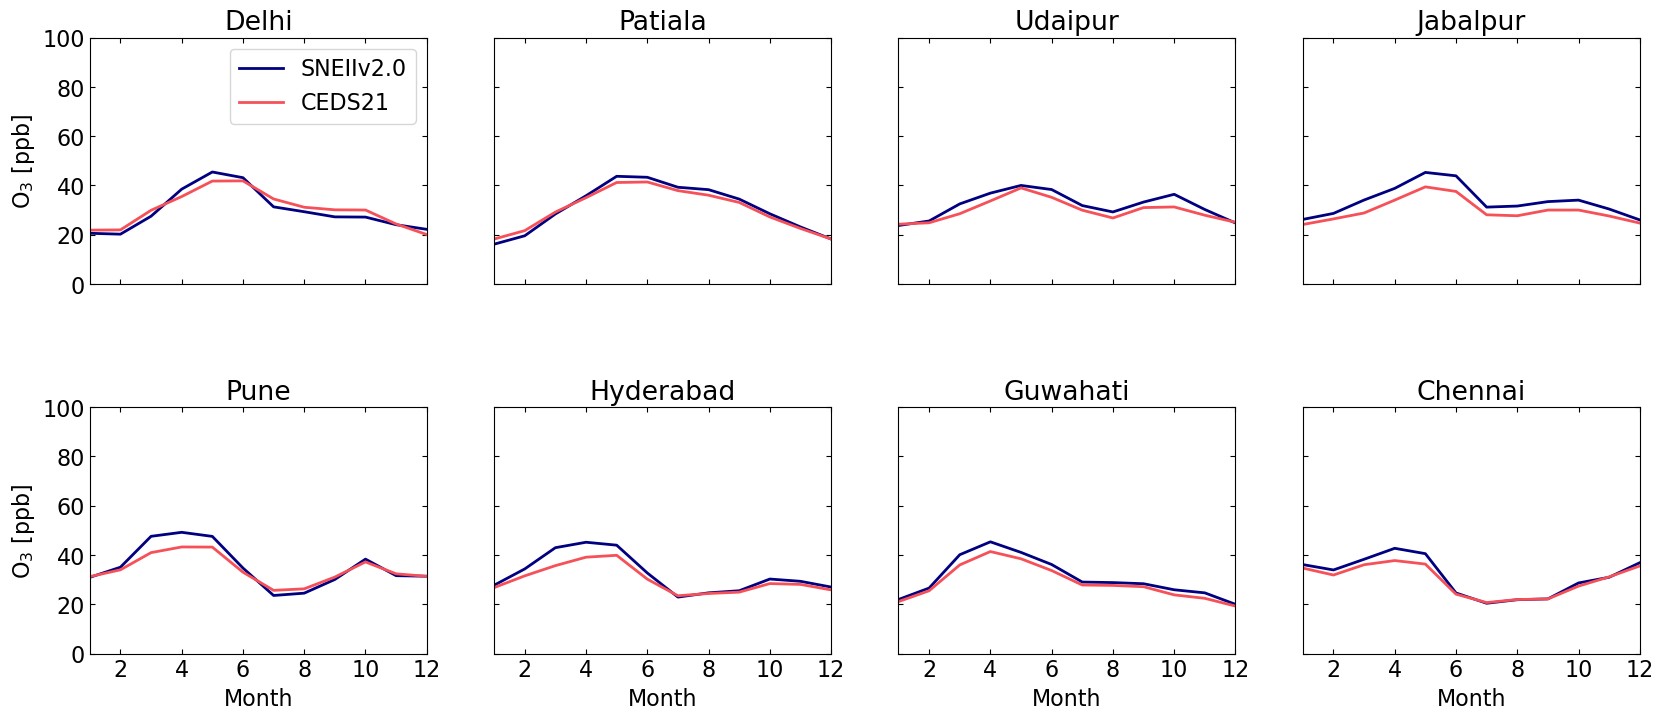

In [30]:
#OsloCTM3 results plot for obs station locations
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Surface ozone", fontsize=16, y=0.95)

# loop through tickers and axes
for ax,i in zip(axs.ravel(),np.arange(0,8)):
    # filter df for ticker and plot on specified axes
    calcs['SNEII'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
    calcs['CEDS'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)
    #calcs['OsloCTM3'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'OsloCTM3')
    #calcs['LMDZ-INCA'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'LMDZ-INCA')


    # chart formatting
    ax.set_xlim(0,11)
    ax.set_ylim(0,100)
    ax.set_xticks(np.arange(1,13,2),labels=[2,4,6,8,10,12])
    #ax.get_legend().remove()
    ax.set_title(station_labs[i])
    ax.set_ylabel(f'O$_3$ [ppb]')
    ax.set_xlabel("Month")
    ax.label_outer()
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0)

    ax.xaxis.set_tick_params(direction='in', which='both',top=True)
    ax.yaxis.set_tick_params(direction='in', which='both',right=True)

    if i == 0:
        ax.legend()
        
plt.show()


fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0)


# If we don't specify the edgecolor and facecolor for the figure when
# saving with savefig, it will override the value we set earlier!
fig.savefig('o3_stations.png', facecolor=fig.get_facecolor(), edgecolor='none')
#plt.savefig('o3_stations.png',transparent=True)

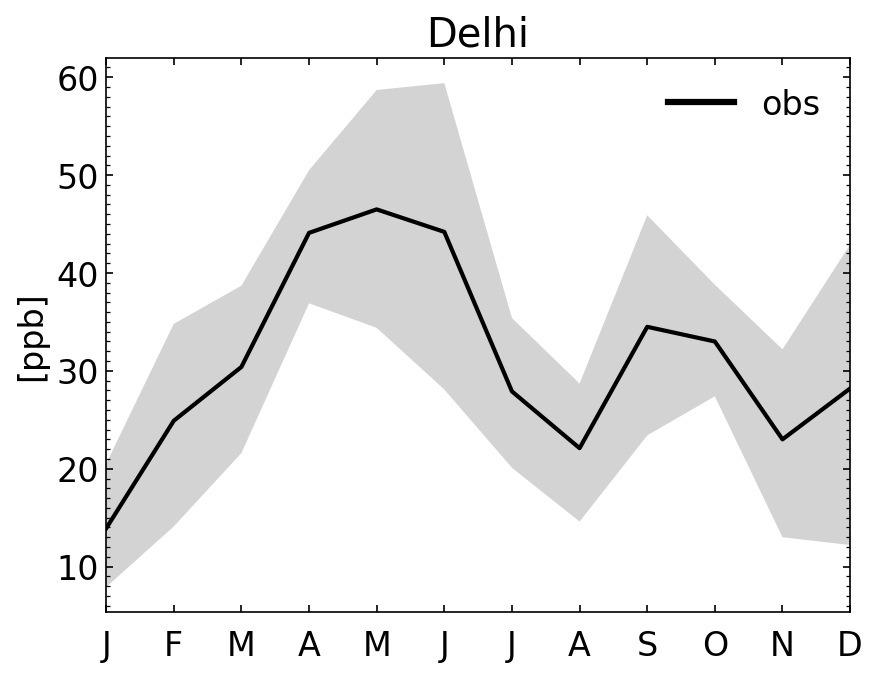

In [31]:
# Station obs plot for one location
fig = plt.figure(dpi=150)
ax = plt.axes()

# filter df for ticker and plot on specified axes
#calcs['EMAC'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'EMAC')
ax.plot(o3_obs_mean.iloc[:,0],label = 'obs', c= ('k'),linewidth=2)
ax.fill_between(o3_obs_max.index, o3_obs_max.iloc[:,0],o3_obs_min.iloc[:,0],facecolor='lightgrey')
#calcs['CEDS'].O3_surf.sel(lat=station_lat_lons[0,1], lon=station_lat_lons[0,0], method='nearest').plot(label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)
#calcs['LMDZ-INCA'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'LMDZ-INCA')


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

# chart formatting
ax.set_xlim(0,11)
ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
#plt.title('Ozone monthly mean (over India land only)')
ax.set_xlabel('')
ax.set_ylabel(f"[ppb]")
leg = plt.legend(frameon=False)
#ax.set_yticks(minor=True)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)

ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.tick_params(axis='y', which='minor', bottom=False)

plt.title(station_labs[0])
for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

#plt.gca().set_aspect(0.45)
    

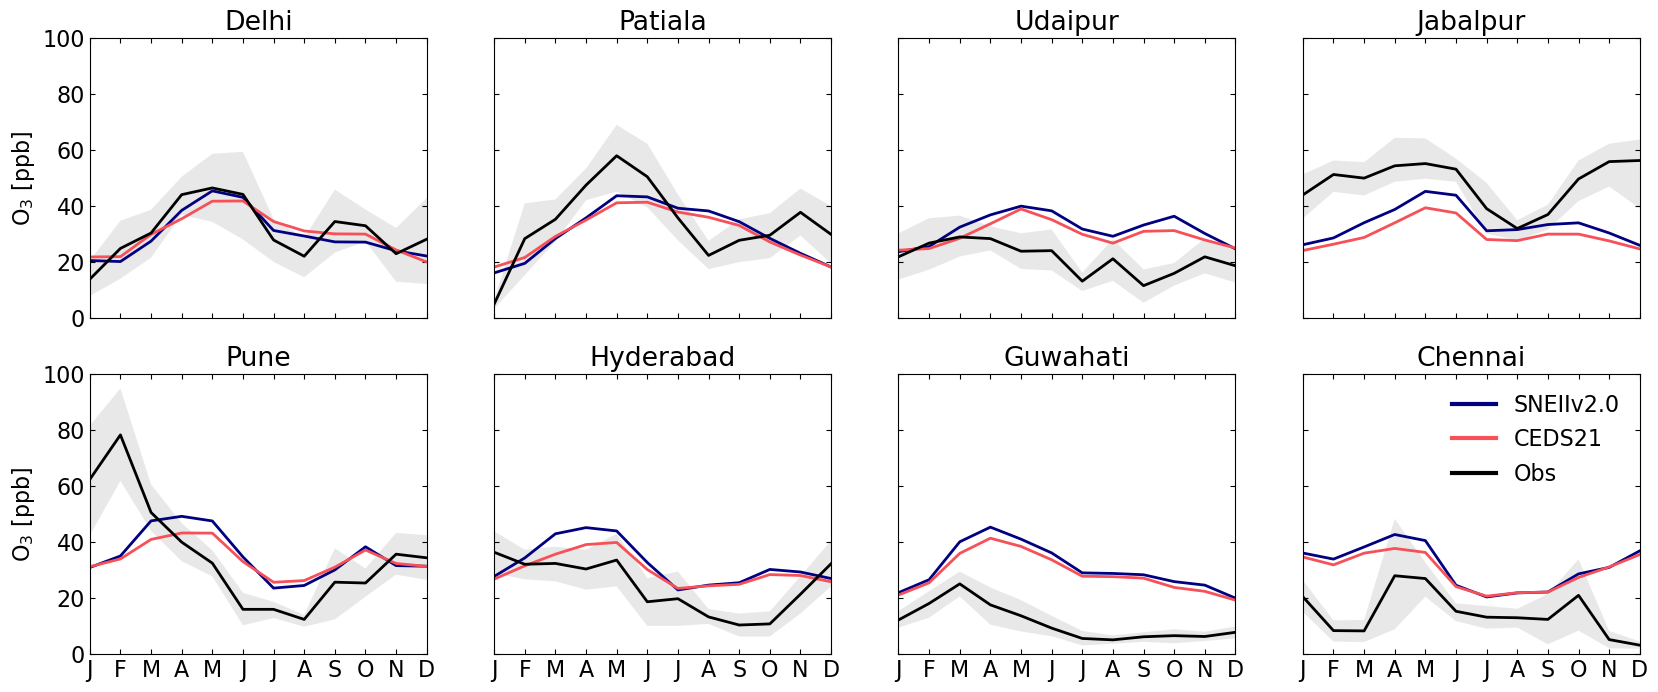

In [32]:
# Obs station plot without multi-model mean
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
#plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Surface ozone", fontsize=16, y=0.95)

# loop through tickers and axes
for ax,i in zip(axs.ravel(),np.arange(0,8)):
    # filter df for ticker and plot on specified axes
    
    calcs['SNEII'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
    calcs['CEDS'].O3_surf.sel(lat=station_lat_lons[i,1], lon=station_lat_lons[i,0], method='nearest').plot(ax=ax,label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

    ax.plot(o3_obs_mean.iloc[:,i],label = 'Obs', c= ('k'),linewidth=2,zorder=2)
    ax.fill_between(o3_obs_max.index, o3_obs_max.iloc[:,i],o3_obs_min.iloc[:,i],facecolor='lightgrey',alpha=0.5,zorder=1)

    #ax.fill_between(o3_mod_max.index, o3_mod_max.iloc[:,i],o3_mod_min.iloc[:,i],facecolor='mediumslateblue',alpha=0.2,zorder=0,label='MMM')
    #calcs['OsloCTM3'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'OsloCTM3')
    #calcs['LMDZ-INCA'].RF_BC_W_m_3.sel(time = time1).plot(ax=ax,y='lev', yincrease=False, label = 'LMDZ-INCA')


    # chart formatting
    ax.set_xlim(0,11)
    ax.set_ylim(0,100)
    ax.set_xticks(calcs['CEDS'].O3_india_mean.time.data,month_labs)
    #ax.get_legend().remove()
    ax.set_title(station_labs[i])
    ax.set_ylabel(f'O$_3$ [ppb]')
    ax.set_xlabel("")
    ax.label_outer()
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0)

    ax.xaxis.set_tick_params(direction='in', which='both',top=True)
    ax.yaxis.set_tick_params(direction='in', which='both',right=True)

    if i == 7:
        leg = ax.legend(frameon=False)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3)
        
plt.show()


fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0)


# If we don't specify the edgecolor and facecolor for the figure when
# saving with savefig, it will override the value we set earlier!
fig.savefig(f'{outfile}station_obs_comparison.pdf',format='pdf',bbox_inches='tight')